In [1]:
GROUPS = "5vs5" #4vs4noPDAC024T | 5vs5
NORM = "TMM" # raw_counts | TMM |..?

In [2]:
save_dir = "/home/jacobo/Documents/02_TRANSDUCER/03_IC3Characterization/01_PDX/090721_IC3_Predictive_Model/02_Output/" + GROUPS +"/"
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import NearestCentroid

# Data loading & preprocessing
## Loading

In [15]:
### data
if NORM == "raw counts":
    train = pd.read_csv("01_Input/geneCount_raw_28s_totalRNA.tsv", index_col ="EnsemblID", sep ="\t").T # 28 PDX from Sauyeun
    test = pd.read_csv("01_Input/Human-Tumor_rawcount_Transcriptome.tsv", index_col ="EnsemblID", sep ="\t").T # Initial PDX cohort
    
elif NORM == "TMM":
    train = pd.read_csv("02_Output/sauyeun_tmm.tsv", index_col ="EnsemblID", sep ="\t").T # 28 PDX from Sauyeun
    test = pd.read_csv("02_Output/pacaomics_tmm.tsv", index_col ="EnsemblID", sep ="\t").T # Initial PDX cohort
    
names_correspondance = pd.read_csv("../Remy_processed_data/sample_names_equivalences.tsv", index_col = "fastq_name", sep ="\t")

#### PROBLEM WITH THE IDS of Training 
#### (ie. PDAC207T instead of PDAC00T)
train = train.rename(index = names_correspondance.to_dict()["CITID"])
train.drop(index = "!", inplace = True) # this sample was only ribosome reads

### labels
ic3 = pd.read_csv("../020821_IC3_Into_Two_Groups/02_Output/samplesIC3_" + GROUPS + ".tsv", index_col ="rowname", sep ="\t")
ic3_weights = ic3["ICA3SampleWeight"]
ic3_labels = ic3["groups"]
ic3_labels.dropna(how = "any", inplace = True)

## Preprocessing
- Filter datasets to keep only labeled
- Create the different feature sets

In [16]:
X_train = train.loc[ic3_labels.index,]
y_train = ic3_labels.loc[ic3_labels.index]

X_test = test.loc[ic3_labels.index,]
y_test = y_train

# get the different sets of features
common = np.intersect1d(train.columns, test.columns)

ic3_bicorr = np.zeros(common.shape)
ic3_oacorr = np.zeros(common.shape)

for f in range(len(common)):
    corr_bi = stats.spearmanr(train.loc[ic3_labels.index,common[f]], ic3_weights.loc[ic3_labels.index]) #corr based in the 8 samples
    corr_oa = stats.spearmanr(train.loc[ic3_weights.index,common[f]], ic3_weights.loc[ic3_weights.index]) #corr based in all 28 samples
    ic3_bicorr[f] = np.abs(corr_bi[0])
    ic3_oacorr[f] = np.abs(corr_oa[0])

best_bi_features = common[np.argsort(-1*ic3_bicorr)] # -1* to get descending order
best_bi_features = best_bi_features[:10**3]

best_oa_features = common[np.argsort(-1*ic3_oacorr)] # -1* to get descending order
best_oa_features = best_oa_features[:10**3]

mostvar_features = np.std(train.loc[:,common],0)
mostvar_features = mostvar_features[np.argsort(-1*mostvar_features,)] # -1* to get descending order
mostvar_features = mostvar_features[:10**3].index

/home/jacobo/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Data visualization
vis different feature sets and standarizations by different decomposition methods

all
    original
    mean centered
    standarized
    yeo-johnson


/home/jacobo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


most correlated with subset IC3
    original
    mean centered
    standarized
    yeo-johnson


/home/jacobo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


most correlated with overall IC3
    original
    mean centered
    standarized
    yeo-johnson


/home/jacobo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


hightest variance
    original
    mean centered
    standarized
    yeo-johnson


/home/jacobo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jacobo/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/jacobo/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/jacobo/anaconda3/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/jacobo/anaconda3/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger tha

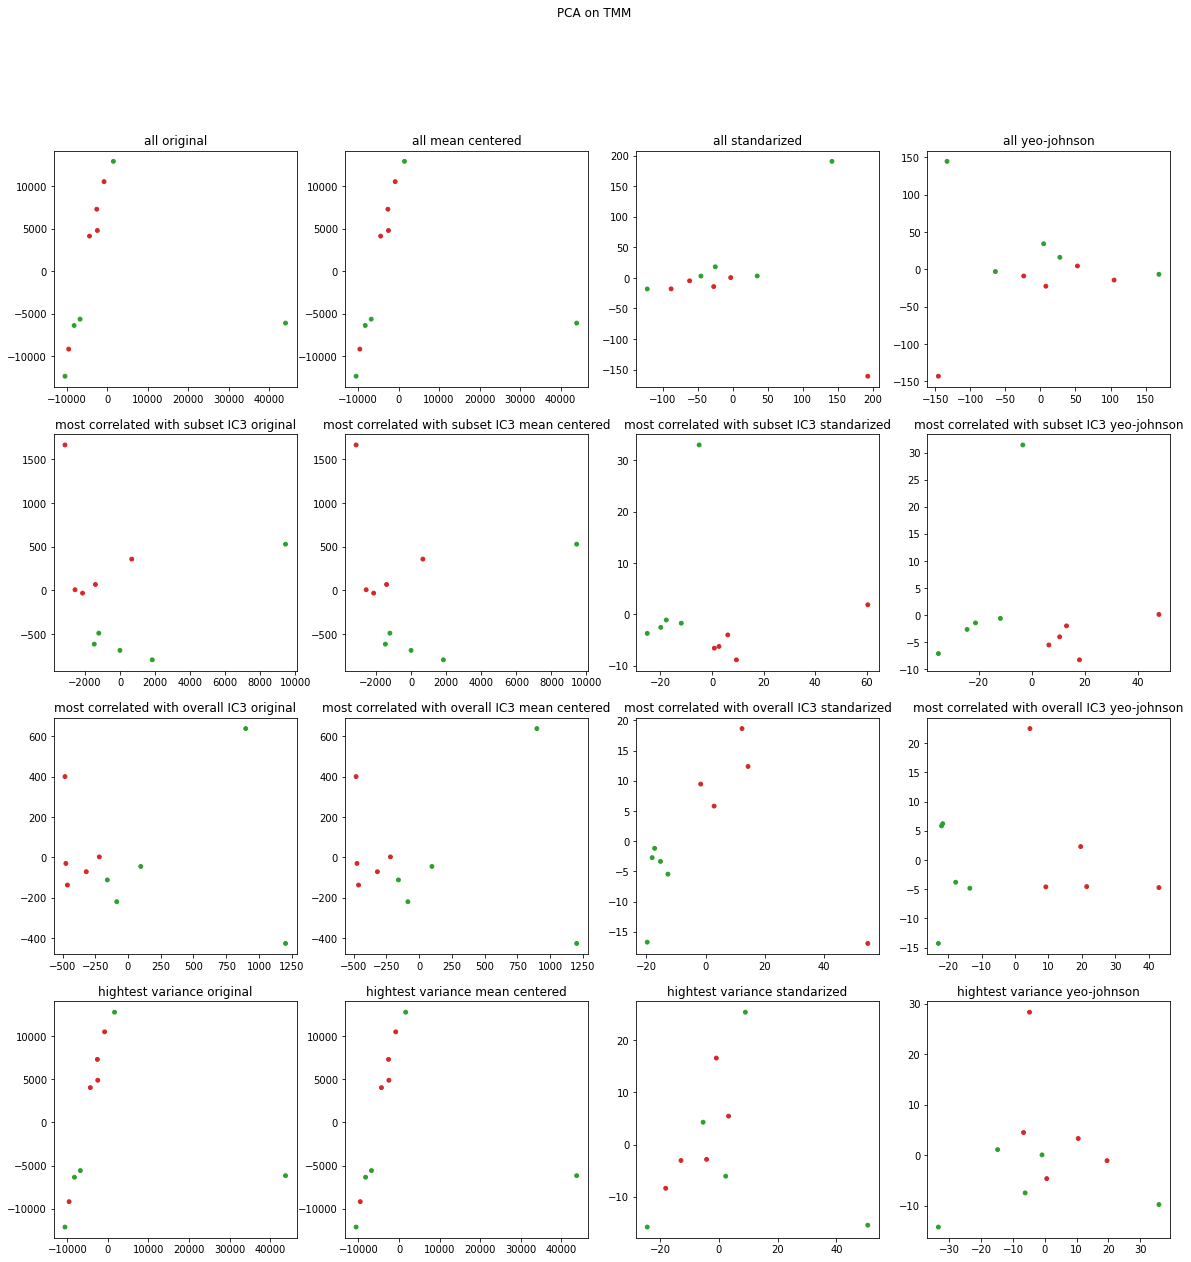

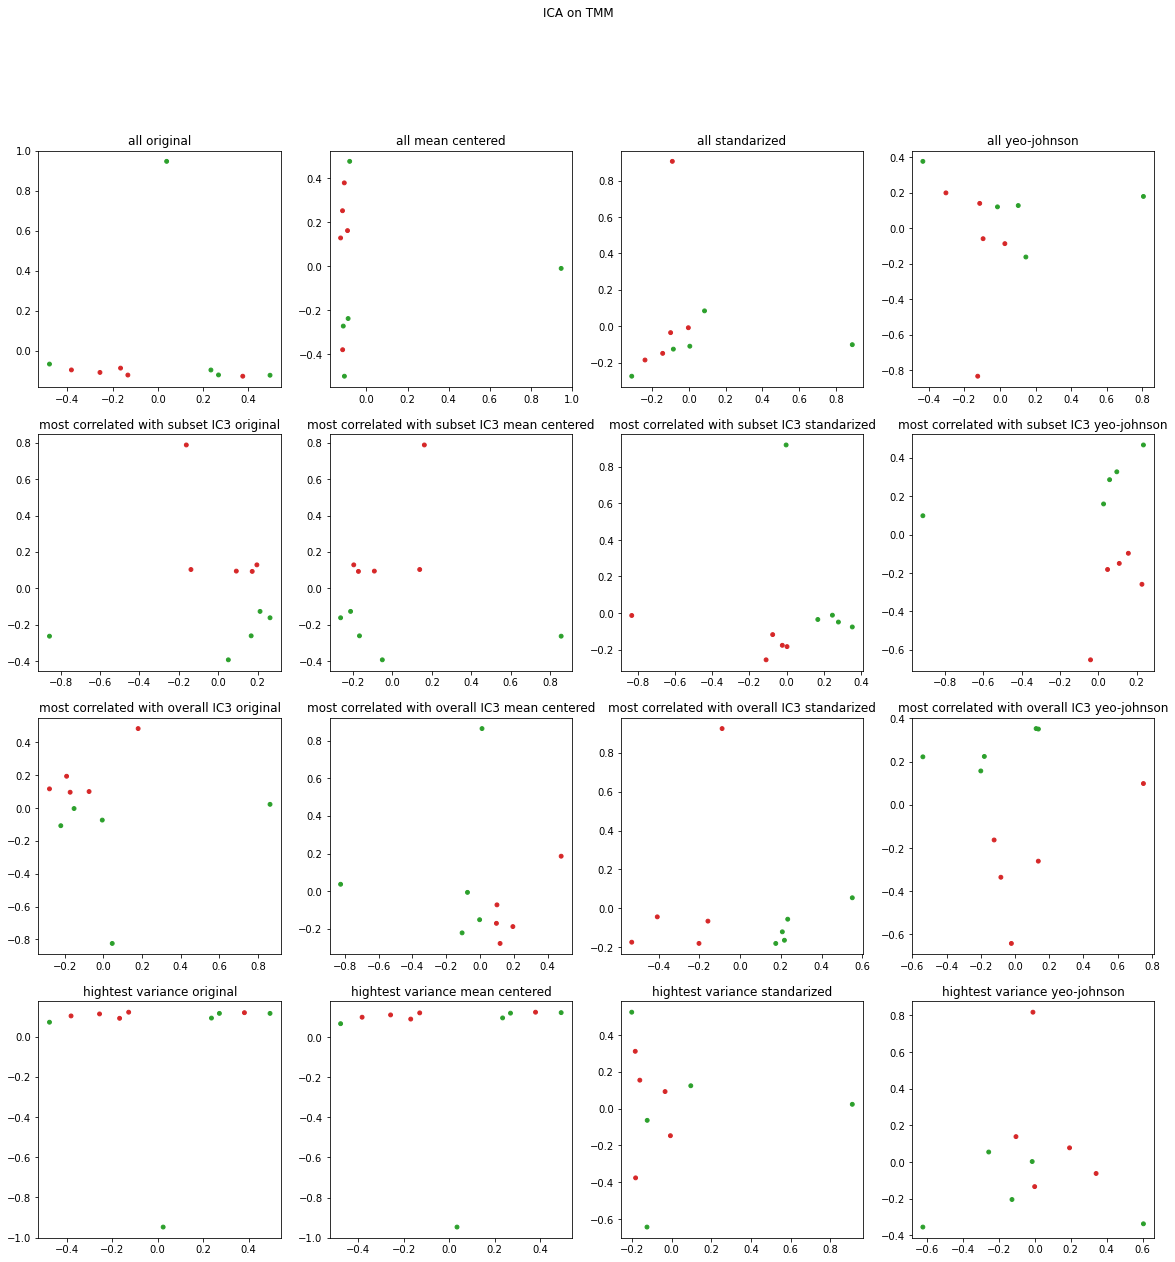

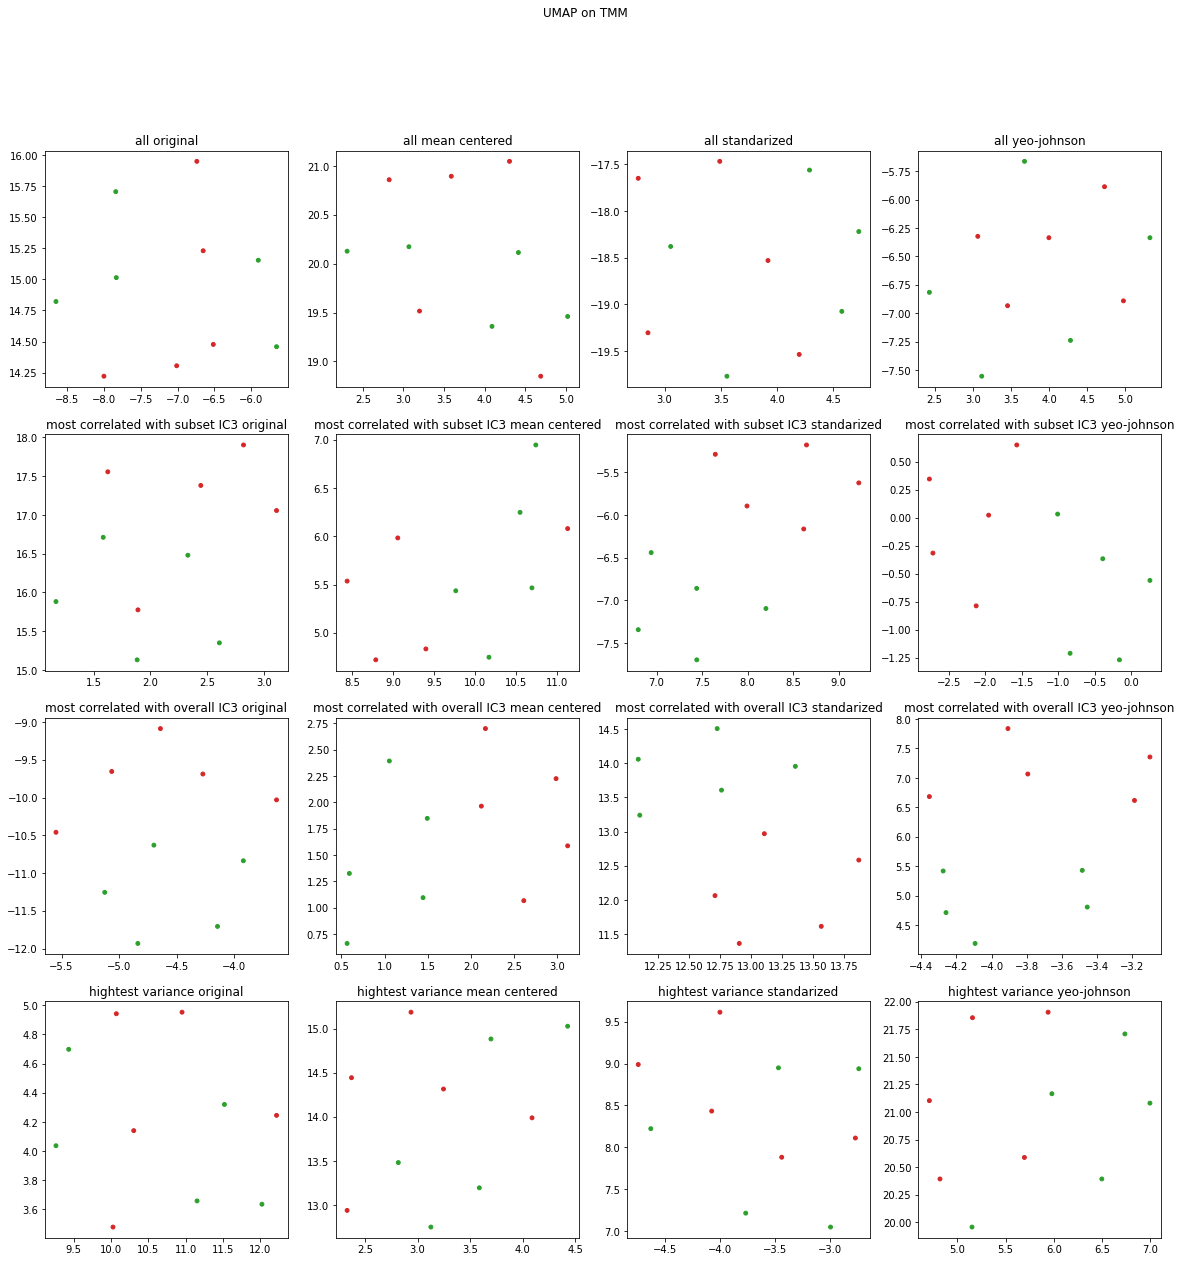

In [17]:
# Data exploration
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA, FastICA, KernelPCA
import umap
from copy import deepcopy

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, input_array, y=None):
        return self
    def transform(self, input_array, y=None):
        return input_array*1

transfos = [IdentityTransformer(), StandardScaler(with_std = False), StandardScaler(), PowerTransformer(method='yeo-johnson')]
transfo_names = ['original', 'mean centered', 'standarized', 'yeo-johnson']

features = [X_train[common], X_train[best_bi_features], X_train[best_oa_features], X_train[mostvar_features]]
features_names = ["all", "most correlated with subset IC3", "most correlated with overall IC3" ,"hightest variance"]


nb_transfo = len(transfos)
nb_features = len(features)

# Compute and store transformed data
features_transfo = []
features_transfo_names = []
for i, (data, data_name) in enumerate(zip(features, features_names)):
    print(data_name)
    new_data = []
    new_names = []
    for j, (transfo, transfo_name) in enumerate(zip(transfos, transfo_names)):
        print(' ' * 4 + transfo_name)
        new_data.append(transfo.fit_transform(data.values))
        new_names.append(data_name + ' ' + transfo_name)
    features_transfo.append(deepcopy(new_data))
    features_transfo_names.append(deepcopy(new_names))
    
# Plot
dataset_color_mapper = {
   'low_IC3': 'tab:red',
   'high_IC3': 'tab:green',
}
colors = y_train.map(dataset_color_mapper)
marker = 'o'
s = 15
base_fs = 5 # base figsize for subplots
path_fig = save_dir
# ------ Dimensionality reduction and visualization ------
reducers = [PCA, FastICA, umap.UMAP]
reducers_names = ['PCA', 'ICA', 'UMAP']
for reducer, reducer_name in zip(reducers, reducers_names):
    fig, axs = plt.subplots(
        nrows=nb_features,
        ncols=nb_transfo,
        figsize=(nb_transfo * base_fs, nb_features * base_fs),
        )
    for i in range(nb_features):
        for j in range(nb_transfo):
            ax = axs[i, j]
            data = reducer(n_components=2).fit_transform(features_transfo[i][j])
            data_name = features_transfo_names[i][j]
            ax.scatter(data[:, 0], data[:, 1], c=colors, marker=marker, s=s)
            #plot labels
            #for t in range(data.shape[0]):
            #    ax.text(x=data[t, 0]+1,y=data[t, 1]+1,s=X_train.index[t], # the order is kept
            #    fontdict=dict(color='red',size=6),
            #    bbox=dict(facecolor='yellow',alpha=0.5))
            
            ax.set_title(data_name);
    title = f'{reducer_name} on {NORM}'
    fig.suptitle(title, fontsize='large');
    # plt.tight_layout()
    # plt.legend(handles=[p1, p2], title='', bbox_to_anchor=(1.05, 1), loc='lower left')
    fig.savefig( path_fig + title)

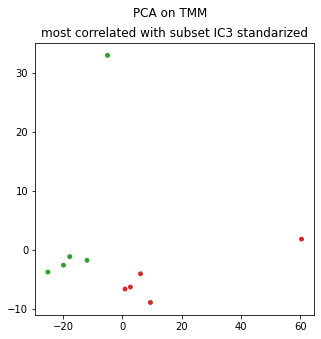

In [6]:
# Most important genes of some data transformation in particular

tn = 'standarized'
fn = "most correlated with subset IC3"
rn = "PCA"

## parse the parameters
feats = features[features_names.index(fn)]
transfo = transfos[transfo_names.index(tn)]
reducer = reducers[reducers_names.index(rn)]

features_transfo = transfo.fit_transform(feats.values)
features_transfo_name = fn + ' ' + tn

# Plot
dataset_color_mapper = {
   'low_IC3': 'tab:red',
   'high_IC3': 'tab:green',
}
colors = y_train.map(dataset_color_mapper)
marker = 'o'
s = 15
base_fs = 5 # base figsize for subplots

# ------ Dimensionality reduction and visualization ------

## plot the transformation to check
fig, ax = plt.subplots(figsize = [5,5])
reducer = reducer(n_components=2)
data = reducer.fit_transform(features_transfo)
data_name = features_transfo_name
ax.scatter(data[:, 0], data[:, 1], c=colors, marker=marker, s=s)

#for t in range(data.shape[0]):
#    ax.text(x=data[t, 0]+1,y=data[t, 1]+1,s=X_train.index[t], # the order is kept
#    fontdict=dict(color='red',size=10),
#    bbox=dict(facecolor='yellow',alpha=0.5))

ax.set_title(data_name);
title = f'{rn} on {NORM}'
fig.suptitle(title, fontsize='large')
plt.show();

In [7]:
## PCA exploration
print("dimension explained variance: ", reducer.explained_variance_ratio_)

n_pcs= reducer.components_.shape[0]

# construct dataframe
ensembl_importances = pd.DataFrame(reducer.components_).T # .components_ has a matrix of PC weights across the orifinal gene order
ensembl_importances.columns = ["".join(["PC",str(1+i)])for i in range(n_pcs)]
ensembl_importances.index = feats.columns

# translation to gene symbols
ensembl_to_genenames = pd.read_csv("01_Input/GRCh37.p13_ensemblvsgenename.txt", #Biomart
                                   index_col ="Gene stable ID", sep ="\t")

ensembl_to_genenames = ensembl_to_genenames.loc[ensembl_importances.index,].to_dict()
gene_importances = ensembl_importances.rename(index = ensembl_to_genenames["Gene name"])

abs_importance = np.argsort(-1*np.abs(gene_importances["PC1"])).values
rel_importance = np.argsort(-1*gene_importances["PC1"]).values

gene_importances.iloc[abs_importance,].to_csv("02_Output/" + GROUPS + "/best_PC1_genes.tsv", sep="\t")
gene_importances.iloc[rel_importance,0].to_csv("02_Output/" + GROUPS + "/ranked_PC1.rnk", sep="\t") #.rnk for GSEA

dimension explained variance:  [0.52888173 0.12934484]


In [8]:
# Data election
X_train = train.loc[ic3_labels.index,best_bi_features]
y_train = ic3_labels.loc[ic3_labels.index]

X_test = test.loc[ic3_labels.index,best_bi_features]
y_test = y_train

In [9]:
np.all(X_train.columns == X_test.columns)

True

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

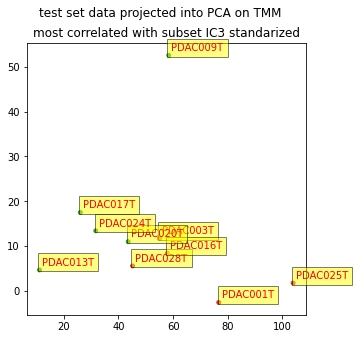

In [11]:
# test data projected in training's PCA
data = reducer.transform(X_test_s)
dataset_color_mapper = {
   'low_IC3': 'tab:red',
   'high_IC3': 'tab:green',
}
colors = y_test.map(dataset_color_mapper)
marker = 'o'
s = 15
base_fs = 5

fig, ax = plt.subplots(figsize = [5,5])
ax.scatter(data[:, 0], data[:, 1], c=colors, marker=marker, s=s)

for t in range(data.shape[0]):
    ax.text(x=data[t, 0]+1,y=data[t, 1]+1,s=X_train.index[t], # the order is kept
    fontdict=dict(color='red',size=10),
    bbox=dict(facecolor='yellow',alpha=0.5))
title = f'test set data projected into {rn} on {NORM} '
ax.set_title(data_name);
fig.suptitle(title, fontsize='large')
plt.show();

# Classification:
## Nearest centroid on Genes

In [12]:
model = NearestCentroid()
cv = LeaveOneOut()
# define grid
grid = dict()
grid['shrink_threshold'] =  stats.uniform(0, 1)
grid['metric'] = ['euclidean', 'manhattan']
n_iter_search = 100

In [13]:
# train
search = RandomizedSearchCV(model, grid, n_iter=n_iter_search, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(X_train_s, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 1.000
Config: {'metric': 'euclidean', 'shrink_threshold': 0.6766267782213995}


       metric  shrink_threshold  Mean accuracy
0   euclidean          0.676627            1.0
1   manhattan          0.896056            0.9
2   manhattan          0.903340            0.9
3   manhattan          0.049133            1.0
4   euclidean          0.005014            1.0
..        ...               ...            ...
95  manhattan          0.896163            0.9
96  manhattan          0.087115            1.0
97  euclidean          0.594080            1.0
98  euclidean          0.197083            1.0
99  euclidean          0.460529            1.0

[100 rows x 3 columns]


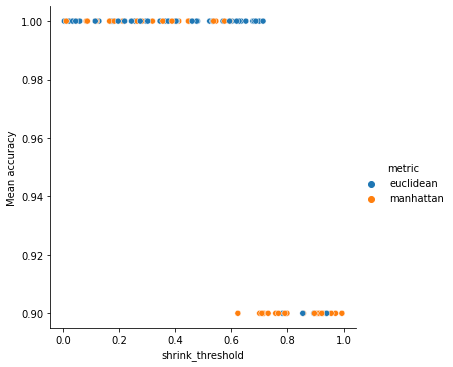

In [14]:
all_CVs = pd.DataFrame(results.cv_results_['params'])
all_CVs["Mean accuracy"] = results.cv_results_['mean_test_score']
print(all_CVs)

sns.relplot(
    data=all_CVs,
    x="shrink_threshold", y="Mean accuracy",
    hue="metric")

In [ ]:
from sklearn import metrics
# final model
#model = NearestCentroid(
#    shrink_threshold= results.best_params_["shrink_threshold"] ,
#    metric = results.best_params_["metric"])

model = NearestCentroid(
    shrink_threshold= 0.53,
    metric = "manhattan")

model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)
print(metrics.classification_report(y_test, y_pred))

In [ ]:
y_test

### Extension
#### 28 PDX set

In [ ]:
X_PDX28 = train.loc[ic3_weights.index,best_bi_features] # so it has 28 samples
X_PDX28_s = scaler.transform(X_PDX28)

In [ ]:
y_PDX28 = model.predict(X_PDX28_s)
y_PDX28 = pd.Series(y_PDX28, index= X_PDX28.index)

In [ ]:
# test data projected in training's PCA
data = reducer.transform(X_PDX28_s)
dataset_color_mapper = {
   'low_IC3': 'tab:red',
   'high_IC3': 'tab:green',
}
colors = y_PDX28.map(dataset_color_mapper)
marker = 'o'
s = 15
base_fs = 5

fig, ax = plt.subplots(figsize = [5,5])
ax.scatter(data[:, 0], data[:, 1], c=colors, marker=marker, s=s)

#for t in range(data.shape[0]):
#    ax.text(x=data[t, 0]+1,y=data[t, 1]+1,s=X_train.index[t], # the order is kept
#    fontdict=dict(color='red',size=10),
#    bbox=dict(facecolor='yellow',alpha=0.5))
title = f'28PDX training data projected into {rn} on {NORM} '
ax.set_title(data_name);
fig.suptitle(title, fontsize='large')
plt.show();

In [ ]:
check_weights = pd.DataFrame(data, index = ic3_weights.index, columns = ["PC1", "PC2"] )
check_weights["IC3_weights"] = ic3_weights
check_weights["predictions"] = y_PDX28
check_weights

sns.relplot(
    data=check_weights,
    x="PC1", y="IC3_weights",
    hue="predictions",
    palette=["tab:red", "tab:green"])

plt.title("PC1 vs IC3 weights.\n How well does the prediction resemble the IC?");

In [ ]:
sns.relplot(
    data=check_weights,
    x="PC1", y="PC2",
    hue="IC3_weights")

plt.title("PC1 vs IC3 weights.\n How well does the prediction resemble the IC?");

In [ ]:
sns.displot(data=check_weights, x="IC3_weights", kind="kde", color = "black")
sns.rugplot(data=check_weights, x="IC3_weights", hue="predictions", palette=["tab:red", "tab:green"])

## SVC in PC1 & PC2

In [ ]:
model = SVC()
cv = LeaveOneOut()
# define grid
grid = dict()
grid['C'] =  stats.uniform(0, 1)
grid['kernel'] = ['linear', 'poly', 'rbf']
n_iter_search = 100

# TRASH

In [ ]:
print(len(features))
mostvar_features = np.std(train.loc[:,common],0)
mostvar_features[np.argsort(-1*mostvar_features,)] # -1* to get descending order

In [ ]:
y_PDX28

In [ ]:
best_bi_features[0].shape

In [ ]:
len(features[np.argsort(features_abscor)][:10**3])

In [ ]:
a

In [ ]:
ic3.dropna(subset = ["groups"])

In [ ]:
y_test

In [ ]:
ic3_labels.loc[ic3_labels.index]

In [ ]:
y_PDX28

In [ ]:
y_PDX28

In [ ]:
np.all(X_train_s == X_PDX28_s)